# StackOverflowData

In [27]:
import numpy as np
from collections import Counter
from operator import itemgetter
from sklearn import metrics



# if you have labels


'''
    The idea of the function below (map_label) is a simplified approach to what they did in the initial paper. 
    They used the so called Hungarian method in order to optimize the labeling. The optimization is based on the
    ground truth and the labels from the k clustering. Using the example dataset:
    We have 20 000 items split in 20 categories, which means that a certain category has multiple items. 
    The idea of best mapping is to take all tuples from ground truth and prediction per item and count their 
    occurancies. For example (6, 18), 88), 6 being the ground truth and 18 the prediction truth. This 
    combination has occured 88 times but ((6, 3), 116) has occured 116 times, so at the end the function 
    will return 6,3 as best map.
'''

# Mapping Option 1

from munkres import Munkres
def best_map(L1,L2):
    #L1 should be the groundtruth labels and L2 should be the clustering labels we got
    Label1 = np.unique(L1)
    nClass1 = len(Label1)
    Label2 = np.unique(L2)
    nClass2 = len(Label2)
    nClass = np.maximum(nClass1,nClass2)
    G = np.zeros((nClass,nClass))
    for i in range(nClass1):
        ind_cla1 = L1 == Label1[i]
        ind_cla1 = ind_cla1.astype(float)
        for j in range(nClass2):
            ind_cla2 = L2 == Label2[j]
            ind_cla2 = ind_cla2.astype(float)
            G[i,j] = np.sum(ind_cla2 * ind_cla1)
    m = Munkres()
    index = m.compute(-G.T)
    index = np.array(index)
    c = index[:,1]
    newL2 = np.zeros(L2.shape)
    for i in range(nClass2):
        newL2[L2 == Label2[i]] = Label1[c[i]]
    return newL2 


# Mapping Option 2

import munkres
from sklearn.metrics.cluster import contingency_matrix
def translateLabels(masterList, listToConvert):    
    contMatrix = contingency_matrix(masterList, listToConvert)
    labelMatcher = munkres.Munkres()
    labelTranlater = labelMatcher.compute(contMatrix.max() - contMatrix)

    uniqueLabels1 = list(set(masterList))
    uniqueLabels2 = list(set(listToConvert))

    tranlatorDict = {}
    for thisPair in labelTranlater:
        tranlatorDict[uniqueLabels2[thisPair[1]]] = uniqueLabels1[thisPair[0]]

    return [tranlatorDict[label] for label in listToConvert]



# Mapping Option 3

def map_label(true_labels, pred_labels):
    label_pair = list(zip(pred_labels, true_labels))
    count = tuple(Counter(label_pair).items())  #count the appearance of each pair dict principle
    mapping = dict()
    n_label = len(np.unique(true_labels))

    # map most likely labels from prediction to ground truth

    for label in range(n_label):
        tuples = [tup for tup in count if tup[0][0] == label]
        likely_tuple = max(tuples, key=itemgetter(1))[0] # tuple as input and take the one which appears the most from the list
        mapping[likely_tuple[0]] = likely_tuple[1]

    pred_labels_mapped = [mapping[x] for x in pred_labels]
    return pred_labels_mapped


# Evaluate cluster quality - if you have labels

def cluster_quality(true_labels, pred_labels, show=True):
    h, c, v = metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    rand = metrics.adjusted_rand_score(true_labels, pred_labels)
    #pred_labels_mapped = best_map(true_labels,pred_labels) # First variation of Hungarian Method
    #pred_labels_mapped = translateLabels(true_labels,pred_labels) # Second variation with Hungarian Method
    pred_labels_mapped = map_label(true_labels, pred_labels) # basic func
    # all mappings have similar results
    acc = metrics.accuracy_score(true_labels, pred_labels_mapped)
    '''
    if show:
        print("Homogeneity: %0.3f" % h)
        print("Completeness: %0.3f" % c)
        print("V-measure: %0.3f" % v)
        print("NMI: %0.3f" % nmi)
        print("Rand score: %0.3f" % rand)
        print("Accuracy: %0.3f" % acc)
        '''
    return dict(
        homogeneity=round(h,3),
        completeness=round(c,3),
        vmeasure=round(v,3),
        nmi=round(nmi,3),
        rand=round(rand,3),
        accuracy=round(acc,3),
    )


In [28]:
import os

from gensim.models.keyedvectors import KeyedVectors
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

############################
# Loading Data
############################

EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin' # word vectors
text_path = 'data/StackOverflow.txt'# data without labels
#text_path = 'data/blq.txt'# data without labels - Own Data
label_path = 'data/StackOverflow_gnd.txt' # labels per row in the data file

with open(text_path) as f:
    data = [text.strip() for text in f]

with open(label_path) as f:
    target = f.readlines()
    
target = [int(label.rstrip('\n')) for label in target] # the data has /n at the end of each row

print("Total: %s short texts" % format(len(data), ","))

Total: 20,000 short texts


In [29]:
############################
# Preprocessing
############################

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(data)
sequences_full = tokenizer.texts_to_sequences(data) # replace words/tokens with numbers

word_index = tokenizer.word_index # get the coresponing word:number dict format
print('Found %s unique tokens.' % len(word_index))
MAX_NB_WORDS = len(word_index) # all words - len

seq_lens = [len(s) for s in sequences_full] # get the count of words/symbols in the sequence from above
print("Minumum length: %d" % min(seq_lens))
print("Average length: %d" % np.mean(seq_lens))
print("Max length: %d" % max(seq_lens))
MAX_SEQUENCE_LENGTH = max(seq_lens)

X = pad_sequences(sequences_full, maxlen=MAX_SEQUENCE_LENGTH) # uses the len of the list and max len
y = target # we take the target values

'''
    pad_sequences is used to ensure that all sequences in a list have the same length. By default this 
    is done by padding 0 in the beginning of each sequence until each sequence has the same 
    length as the longest sequence.
'''

Found 11365 unique tokens.
Minumum length: 1
Average length: 8
Max length: 34


'\n    pad_sequences is used to ensure that all sequences in a list have the same length. By default this \n    is done by padding 0 in the beginning of each sequence until each sequence has the same \n    length as the longest sequence.\n'

In [30]:
############################
# Preparing embedding matrix
############################


print('Preparing embedding matrix')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM)) # Init as 0's and updated if in word2vec
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
    #else:
        #print(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 4269


In [31]:
#################################################
# Preparing target using Average embeddings (AE)
#################################################
Y = {}
tfidf_seq = tokenizer.sequences_to_matrix(sequences_full, mode='tfidf') # converting List of sequences (a sequence is a list of integer word indices).
# TF-IDF Acc: 0,329
binary_seq = tokenizer.sequences_to_matrix(sequences_full, mode='binary') # Acc: 0,458
count_seq = tokenizer.sequences_to_matrix(sequences_full, mode='count') # Acc: 0,467
frequency_seq = tokenizer.sequences_to_matrix(sequences_full, mode='freq') # Acc: 0452
from sklearn.preprocessing import Normalizer
normed_value = Normalizer().fit_transform(binary_seq)
average_embeddings = np.dot(normed_value, embedding_matrix)
Y["ae"] = average_embeddings
print("Shape of average embedding: ", Y['ae'].shape)


# binary Y
from sklearn import preprocessing
reduction_name = "ae"
B = preprocessing.Binarizer().fit_transform(Y[reduction_name]) # binarizing the whole value list for ae key (which is the only key)

# Shape of last dimension in the CNN
TARGET_DIM = B.shape[1]

# Example of binarized target vector
print(B.shape)
print(B[1])

Shape of average embedding:  (20000, 300)
(20000, 300)
[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]


In [32]:
###############PLAYING-GridSearch#################################
# Playing train model
################################################

# Best accuracy for now

import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Activation, concatenate, Input
from keras.layers import Embedding, Conv1D, SpatialDropout1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint

#https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network
# the above link has to do with dropout positioning

# https://github.com/keras-team/keras/issues/7290
# has to do with spatial dropout after embedding layer

# https://towardsdatascience.com/review-tompson-cvpr15-spatial-dropout-human-pose-estimation-c7d6a5cecd8c
# SpatialDropout again

def get_model():
    embedding_matrix_copy = embedding_matrix.copy()
    trainable_embedding = False
    #filters = [2,3,4]
    filters = [3,4,5]
    # Embedding layer
    pretrained_embedding_layer = Embedding(
        input_dim=nb_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
    )

    # Input
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = pretrained_embedding_layer(sequence_input)
    
    # DropOut
    #x = Dropout(0.2)(embedded_sequences)
    spatial_x = SpatialDropout1D(0.2)(embedded_sequences)
    #spatial_x = SpatialDropout1D(0.1)(embedded_sequences) # initial but then changed to the one above
    # 1st Layer
    conv_layers = []
    for i in filters:
        x = Conv1D(125, i, activation='tanh', padding='same')(spatial_x)
        x = GlobalMaxPooling1D()(x)
        #x = Dropout(0.2)(x)
        conv_layers.append(x)
    merged = concatenate(conv_layers)
    # Dense
    x = Dense(256,activation = 'tanh')(merged)
    
    # DropOut
    x = Dropout(0.2)(x)
    #x = Dropout(0.1)(x)# initial but then changed to the one above
    # Output
    predictions = Dense(TARGET_DIM, activation='sigmoid')(x) 
    # sigmoid because we want 0,1 for one of the categories
    
    model = Model(sequence_input, predictions)

    model.layers[1].trainable=trainable_embedding #embedding layer

    #adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #standard for keras
    #optimizer = Adam(lr=learn_rate)
    
    # Loss and Optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy','mae'])
    
    # Fine-tune embeddings or not
    model.summary()
    
    return model

In [ ]:
# Grid Search with best model
# Use scikit-learn to grid search the number of neurons
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
model = KerasClassifier(build_fn=get_model, epochs=50, batch_size=100,verbose=0)

# define the grid search parameters

#activ = ['relu', 'tanh', 'sigmoid']
#optimizers = ['Nadam','Adam']
droupou = [0.1,0.2,0.3]
#init_mode = ['uniform', 'lecun_uniform']
#filters =[100,120]
#size = [100,120,125]
#filterme = [[3,4,5], [2,3,4]]
#batch_size = [200]
#epochs = [120]
#learn_rate = [0.001, 0.01, 0.02, 0.1]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(droupout = droupou)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs= -1)
grid_result = grid.fit(X, B)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [33]:
# 25 epoch and 80 batch = 50.3 accuracy
nb_epoch = 50
checkpoint = ModelCheckpoint('models/weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
model = get_model()
history = model.fit(X, B, validation_split=0.2,
              epochs=nb_epoch, batch_size=100, verbose=1, shuffle=True)

# create model that gives penultimate layer (предпоследно)
input1 = model.layers[0].input
output = model.layers[-2].output

model_penultimate = Model(input1, output)

# inference of penultimate layer
H = model_penultimate.predict(X)
#H = model.predict(X)
print("Sample shape: {}".format(H.shape))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 300)      3409800     input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 34, 300)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 34, 125)      112625      spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
conv1d_8 (

16000/16000 [==============================] - 21s 1ms/step - loss: 0.3019 - acc: 0.8649 - mean_absolute_error: 0.1923 - val_loss: 0.3020 - val_acc: 0.8654 - val_mean_absolute_error: 0.1973
Epoch 26/50
16000/16000 [==============================] - 24s 1ms/step - loss: 0.3009 - acc: 0.8655 - mean_absolute_error: 0.1916 - val_loss: 0.3009 - val_acc: 0.8660 - val_mean_absolute_error: 0.1964
Epoch 27/50
16000/16000 [==============================] - 19s 1ms/step - loss: 0.2998 - acc: 0.8661 - mean_absolute_error: 0.1908 - val_loss: 0.3001 - val_acc: 0.8663 - val_mean_absolute_error: 0.1958
Epoch 28/50
16000/16000 [==============================] - 23s 1ms/step - loss: 0.2994 - acc: 0.8662 - mean_absolute_error: 0.1904 - val_loss: 0.2992 - val_acc: 0.8666 - val_mean_absolute_error: 0.1953
Epoch 29/50
16000/16000 [==============================] - 18s 1ms/step - loss: 0.2987 - acc: 0.8667 - mean_absolute_error: 0.1898 - val_loss: 0.2986 - val_acc: 0.8670 - val_mean_absolute_error: 0.1945
Ep

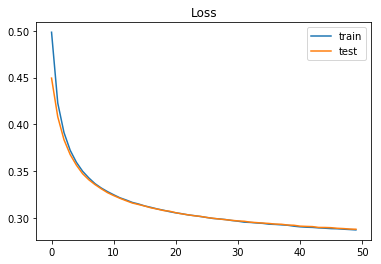

In [34]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

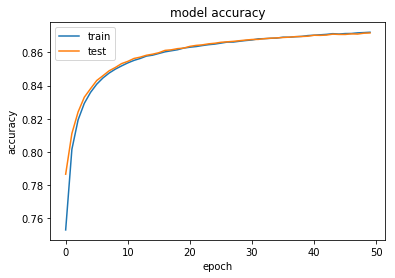

In [35]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

true_labels = y
n_clusters = len(np.unique(y))
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result = dict()
V = normalize(H, norm='l2')
km.fit(V)
pred = km.labels_
pred1 = km.cluster_centers_
print(pred)
a = cluster_quality(true_labels, pred)
#np.save("pred.npy", pred)


Number of classes: 20
[12 12  6 ...  0  0 16]


In [37]:
print(a)

{'homogeneity': 0.455, 'completeness': 0.481, 'vmeasure': 0.468, 'nmi': 0.468, 'rand': 0.282, 'accuracy': 0.508}


# Running clusterS

In [38]:
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

# clustering loop
true_labels = y
n_clusters = len(np.unique(y))
#print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result = dict()
V = normalize(H, norm='l2')
df = pd.DataFrame()
for i in range(100):
    km.fit(V)
    pred = km.labels_
    pred1 = km.cluster_centers_
    #print(pred)
    a = cluster_quality(true_labels, pred)
    df = df.append([a],ignore_index=True)
    print('Run {} was completed!'.format(i))   

Run 0 was completed!
Run 1 was completed!
Run 2 was completed!
Run 3 was completed!
Run 4 was completed!
Run 5 was completed!
Run 6 was completed!
Run 7 was completed!
Run 8 was completed!
Run 9 was completed!
Run 10 was completed!
Run 11 was completed!
Run 12 was completed!
Run 13 was completed!
Run 14 was completed!
Run 15 was completed!
Run 16 was completed!
Run 17 was completed!
Run 18 was completed!
Run 19 was completed!
Run 20 was completed!
Run 21 was completed!
Run 22 was completed!
Run 23 was completed!
Run 24 was completed!
Run 25 was completed!
Run 26 was completed!
Run 27 was completed!
Run 28 was completed!
Run 29 was completed!
Run 30 was completed!
Run 31 was completed!
Run 32 was completed!
Run 33 was completed!
Run 34 was completed!
Run 35 was completed!
Run 36 was completed!
Run 37 was completed!
Run 38 was completed!
Run 39 was completed!
Run 40 was completed!
Run 41 was completed!
Run 42 was completed!
Run 43 was completed!
Run 44 was completed!
Run 45 was completed

In [ ]:
## OLD
'''
import statistics 
# round up this and the ones below in function to end up with a table for the paper
dfToList_NMI = df['nmi'].tolist()
dfToList_Acc = df['accuracy'].tolist()
lenListACC = len(dfToList_Acc)
lenListACC = len(dfToList_NMI)
sumACC = 0
sumNMI = 0
for i in dfToList_Acc:
    sumACC += i
df['average_acc'] = round(sumACC/lenListACC,3)
df['diff_acc'] = df.apply(lambda x: (x['accuracy'] - x['average_acc']), axis=1)
df['standard_dev'] = df.apply(lambda x: (x['accuracy'] - x['average_acc']), axis=1)

for a in dfToList_NMI:
    sumNMI +=a
    df['average_nmi'] = round(sumNMI/lenListACC,3)
'''

In [ ]:
# using tfidf
df_tfidf = df
max_acc = df_tfidf['accuracy'].max() # 0,581
print('Max accuracy is: {}'.format(max_acc))
min_acc = df_tfidf['accuracy'].min() # 0.463
print('Min accuracy is: {}'.format(min_acc))
average_acc = df_tfidf['average_acc'].max() # 0.514
print('Average accuracy is: {}'.format(average_acc))
standard_dev_acc = statistics.stdev(dfToList_Acc)
print('Standar deviation (Accuracy) is: {}'.format(standard_dev_acc))
standard_dev_nmi = statistics.stdev(dfToList_NMI)
print('Standar deviation (NMI) is: {}'.format(standard_dev_nmi))
df_tfidf.to_csv('100cluster_TF-IDFBased.csv')
df_tfidf.head(5)

In [ ]:
# using count
import statistics 
df_count = df
max_acc = df_count['accuracy'].max() # 0,581
print('Max accuracy is: {}'.format(max_acc))
min_acc = df_count['accuracy'].min() # 0.463
print('Min accuracy is: {}'.format(min_acc))
average_acc = df_count['accuracy'].mean() # 0.514
print('Average Accuracy is: {}'.format(average_acc))
average_nmi = df_count['nmi'].mean() # 0.514
print('Average NMI is: {}'.format(average_nmi))
standard_dev_acc = statistics.stdev(df_count['accuracy'])
print('Standar deviation (Accuracy) is: {}'.format(standard_dev_acc))
standard_dev_nmi = statistics.stdev(df_count['nmi'])
print('Standar deviation (NMI) is: {}'.format(standard_dev_nmi))
df_count.to_csv('100cluster_countBased.csv')
df_count.head(5)

In [39]:
# using binary - new like count

import statistics 
df_binary = df
df_binary['Normal_ACC'] = df_binary['accuracy'].map(lambda a: a * 100)
df_binary['Normal_NMI'] = df_binary['nmi'].map(lambda a: a * 100)

max_acc = df_binary['Normal_ACC'].max() # 0,581
print('Max accuracy is: {}'.format(max_acc))

min_acc = df_binary['Normal_ACC'].min() # 0.463
print('Min accuracy is: {}'.format(min_acc))

average_acc = df_binary['Normal_ACC'].mean() # 0.514
print('Average Accuracy is: {}'.format(average_acc))

average_nmi = df_binary['Normal_NMI'].mean() # 0.514
print('Average NMI is: {}'.format(average_nmi))

standard_dev_acc = statistics.stdev(df_binary['Normal_ACC'])
print('Standar deviation (Accuracy) is: {}'.format(standard_dev_acc))

standard_dev_nmi = statistics.stdev(df_binary['Normal_NMI'])
print('Standar deviation (NMI) is: {}'.format(standard_dev_nmi))

df_binary.to_csv('100cluster_BinaryBased.csv')
df_binary.head(5)

Max accuracy is: 63.7
Min accuracy is: 47.3
Average Accuracy is: 53.412
Average NMI is: 49.56000000000002
Standar deviation (Accuracy) is: 2.6352421160305193
Standar deviation (NMI) is: 2.2714744021441144


,accuracy,completeness,homogeneity,nmi,rand,vmeasure,Normal_ACC,Normal_NMI
0,0.552,0.523,0.496,0.509,0.319,0.509,55.2,50.9
1,0.536,0.505,0.480,0.492,0.301,0.492,53.6,49.2
2,0.517,0.503,0.473,0.488,0.295,0.488,51.7,48.8
3,0.492,0.480,0.451,0.465,0.271,0.465,49.2,46.5
4,0.550,0.523,0.495,0.509,0.311,0.509,55.0,50.9


In [ ]:
# using frequency
df_freq = df
max_acc = df_freq['accuracy'].max() # 0,581
print('Max accuracy is: {}'.format(max_acc))
min_acc = df_freq['accuracy'].min() # 0.463
print('Min accuracy is: {}'.format(min_acc))
average_acc = df_freq['average_acc'].max() # 0.514
print('Average accuracy is: {}'.format(average_acc))
standard_dev_acc = statistics.stdev(dfToList_Acc)
print('Standar deviation (Accuracy) is: {}'.format(standard_dev_acc))
standard_dev_nmi = statistics.stdev(dfToList_NMI)
print('Standar deviation (NMI) is: {}'.format(standard_dev_nmi))
df_freq.to_csv('100cluster_FreqBased.csv')
df_freq.head(5)

In [ ]:
# using binary
df_binary = df
max_acc = df_binary['accuracy'].max() # 0,581
print('Max accuracy is: {}'.format(max_acc))
min_acc = df_binary['accuracy'].min() # 0.463
print('Min accuracy is: {}'.format(min_acc))
average_acc = df_binary['average_acc'].max() # 0.514
print('Average accuracy is: {}'.format(average_acc))
standard_dev_acc = statistics.stdev(dfToList_Acc)
print('Standar deviation (Accuracy) is: {}'.format(standard_dev_acc))
standard_dev_nmi = statistics.stdev(dfToList_NMI)
print('Standar deviation (NMI) is: {}'.format(standard_dev_nmi))
df_binary.to_csv('100cluster_BinaryBased.csv')
df_binary.head(5)

# Save/Load Model 

In [ ]:
from keras.models import model_from_json
# Saving Model and weiths
# serialize model to JSON
'''
model_json = model.to_json()
with open("model_55%.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_55%.h5")
print("Saved model to disk")
'''

# load json and create model
json_file = open('model_55%_StackData.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_55%_StackData.h5")
print("Loaded model from disk")

# Evaluate

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

